In [1]:
import sys
sys.path.insert(1, '/home/afkirby/Analysis')

In [2]:
from read_penguin import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import Geometry as geo
from Interpolate import *
from Search import binSearch
from getQuantity import getVel3D
import time

In [3]:
#Loading Data
xres3d = 288
yres3d = 480
zres3d = 144
data3d = load_3D_data("/scratch/afkirby/3DRsVariation/rs001/", xres3d, yres3d, zres3d, "h50_1p10E_e0_PPM4_ave", 10)

/home/afkirby/Analysis/Geometry.py:28: RuntimeWarning: invalid value encountered in scalar divide
  phi = np.arccos(z/r)


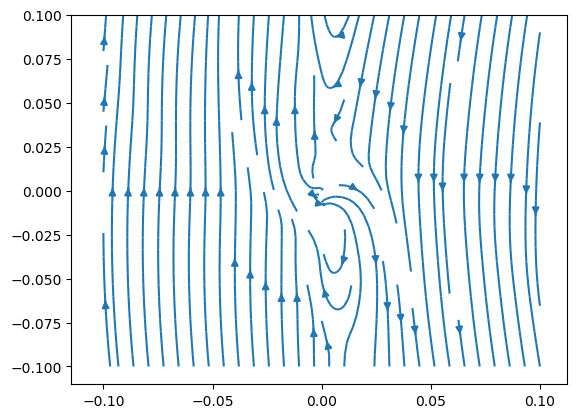

In [9]:
#Planetary Coordinates/Velocity
planetCoords = (1, np.pi, np.pi/2)
planetCoordsCart = geo.sphericalToCartesian(planetCoords, dim = 3)
planetVel = (0, 1, 0)
planetVelCart = geo.sphericalToCartesianVelocity(planetCoords, planetVel, dim = 3)

#Creating Corotating Cartesian Grid
coordX = np.ndarray(1001)
coordY = np.ndarray(1001)
rH = 0.05
for i in range(1001):
    coordX[i] = -2*rH + 4*rH*i/1000
    coordY[i] = -2*rH + 4*rH*i/1000

vxCart = np.ndarray((1001, 1001))
vyCart = np.ndarray((1001, 1001))
for i in range(1001):
    for j in range(1001):
        sphereCoords = geo.cartesianToSpherical((coordX[i], coordY[j],0), 3)
        v = getVel3D(sphereCoords, planetCoords, planetVel, data3d, cart = True)
        vxCart[j,i] = v[0]
        vyCart[j,i] = v[1]



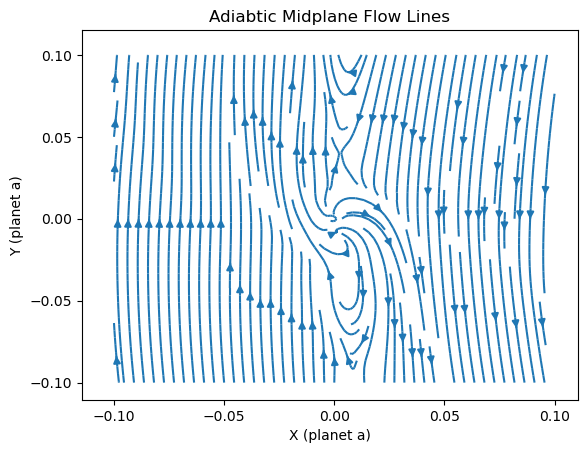

In [11]:
plt.streamplot(coordX, coordY, vxCart, vyCart, density = 1.5)
plt.title("Adiabtic Midplane Flow Lines")
plt.xlabel("X (planet a)")
plt.ylabel("Y (planet a)")
plt.savefig("AdiabaticMidplane.png")

In [6]:
def isoVel(x, y):
    x1 = y[0] #X Position
    x2 = y[1] #Y Position
    
    xVals = coordX
    yVals = coordY
    xPoints = binSearch(xVals, 0, len(xVals), x1)
    yPoints = binSearch(yVals, 0, len(yVals), x2)
    if(xPoints[0] == -np.infty):
        return np.array([0,0])
    elif(xPoints[1] == np.infty):
        return np.array([0,0])
    if(yPoints[0] == -np.infty):
        return np.array([0,0])
    if(yPoints[1] == np.infty):
        return np.array([0,0])
    lowx = xPoints[0]
    highx = xPoints[1]
    lowy = yPoints[0]
    highy = yPoints[1]
    xVel = vxCart
    yVel = vyCart
    xsquareVals = [xVel[lowy,lowx], xVel[highy,lowx], xVel[lowy,highx], xVel[highy,highx]]
    targetCoords = (x1,x2)
    minCoords = (xVals[lowx], yVals[lowy])
    maxCoords = (xVals[highx], yVals[highy])
    vx = biInterpolate(targetCoords, xsquareVals, minCoords, maxCoords)
    
    ysquareVals = [yVel[lowy,lowx], yVel[highy,lowx], yVel[lowy,highx], yVel[highy,highx]]
    targetCoords = (x1,x2)
    minCoords = (xVals[lowx], yVals[lowy])
    maxCoords = (xVals[highx], yVals[highy])
    vy = biInterpolate(targetCoords, ysquareVals, minCoords, maxCoords)
    
    return np.array([vx, vy])
    


def RK45(y0, xi, xf, maxstep, maxerror, fun):
    h = maxstep
    x = xi
    while(True):
        #Calculating k's
        k1 = h*fun(x, y0)
        k2 = h*fun(x+h/4, y0+k1/4)
        k3 = h*fun(x+3*h/8, y0+3*k1/32+9*k2/32)
        k4 = h*fun(x+12*h/13, y0+1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h*fun(x+h, y0 + 439.0*k1/216.0 - 8.0*k2 + 3680*k3/513.0 - 845.0*k4/4104.0)
        k6 = h*fun(x+h/2, y0 - 8.0*k1/27.0 + 2.0*k2 - 3544.0*k3/2565.0 + 1859.0*k4/4104.0 - 11.0*k5/40.0)

        #Calculating 5th order approximation and estimated error
        fourth = (25.0*k1/216.0 + 1408*k3/2565.0 + 2197.0*k4/4104.0 - k5/5.0)
        fifth = (16.0*k1/135.0 + 6656.0*k3/12825.0 + 28561.0*k4/56430.0 - 9.0*k5/50.0 + 2.0*k6/55.0)

        error = (fourth - fifth)/h
        for l in range(len(error)):
            if(error[l] < 0):
                error[l] = -error[l]

        #Finding relative error and adapting step size
        estError = 0
        for i in range(len(error)):
            estError += pow(error[i], 2)
        estError = estError**(1/2)

        if(estError > maxerror):
            h = h*0.9*pow(maxerror/estError, 0.2)
            continue

        if(estError <= maxerror):
            hnew = 1.1*h
            if(h > maxstep):
                hnew = maxstep
            break
    return [fifth, error, h, hnew]


In [7]:
def flowLine(xi, yi, Xs, Ys, maxerror, fun):
    ys = []
    xs = []
    y0 = np.array([xi, yi])
    xf = np.max(Xs)
    yf = np.max(Ys)

    h = abs(xf-xi)
    ys.append(yi)
    xs.append(xi)
    n = 0
    aveCellX = (xf - xi)/len(Xs)
    aveCellY = (yf - yi)/len(Ys)
    while(abs(y0[0]) < 0.99*xf and abs(y0[1]) < 0.99*yf and n < 20000):
        correction = RK45(y0, y0[0], xf, h, maxerror, fun)
        if(abs(correction[0][0]) <= 0.01*aveCellX and abs(correction[0][1]) <= 0.01*aveCellY):
            break
        y0 = y0 + correction[0]
        ys.append(y0[1])
        xs.append(y0[0])
        h = correction[3]
        n = n+1
    y0 = np.array([xi, yi])
    h = abs(xf-xi)
    n = 0
    while(abs(y0[0]) < xf and abs(y0[1]) < yf and n < 20000):
        correction = RK45(y0, y0[0], xf, h, maxerror, fun)
        if(abs(correction[0][0]) <= 0.01*aveCellX and abs(correction[0][1]) <= 0.01*aveCellY):
            break
        y0 = y0 - correction[0]
        ys.insert(0, y0[1])
        xs.insert(0, y0[0])
        h = correction[3]
        n = n+1
    return (xs, ys)

0.2926211357116699


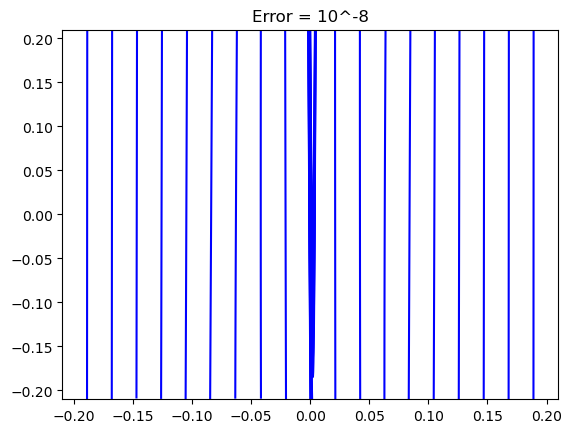

In [8]:
t1 = time.time()
for i in range(10):
    flow = flowLine(0, coordY[-1]*(i+1)/10, coordX, coordY, 1e-8, isoVel)
    plt.plot(flow[0], flow[1], color = 'b')
    flow = flowLine(0, -coordY[-1]*(i+1)/10, coordX, coordY, 1e-8, isoVel)
    plt.plot(flow[0], flow[1], color = 'b')
    flow = flowLine(coordX[-1]*(i+1)/10, 0, coordX, coordY, 1e-8, isoVel)
    plt.plot(flow[0], flow[1], color = 'b')
    flow = flowLine(-coordX[-1]*(i+1)/10, 0, coordX, coordY, 1e-8, isoVel)
    plt.plot(flow[0], flow[1], color = 'b')
plt.ylim(coordY[0], coordY[-1])
plt.xlim(coordX[0], coordX[-1])
plt.title("Error = 10^-8")
print(time.time() - t1)

In [9]:
dataAdi = load_2D_data("/scratch/afkirby/2DAdiabaticParameterChange/Gamma1.5/", xres, yres, "h50_1p1J_e0_PPM4", 100)

#Creating Corotating Cartesian Grid
coordXAdi = np.ndarray(1001)
coordYAdi = np.ndarray(1001)
for i in range(1001):
    coordXAdi[i] = -3*rH + 6*rH*i/1000
    coordYAdi[i] = -3*rH + 6*rH*i/1000
    
vxCartAdi = np.ndarray((1001,1001))
vyCartAdi = np.ndarray((1001,1001))
for i in range(1001):
    for j in range(1001):
        v = tr.findVel2D(coordXAdi[i], coordYAdi[j], dataAdi, planetCoords, planetVel) 
        vxCartAdi[j,i] = v[0]
        vyCartAdi[j,i] = v[1]
    
plt.streamplot(coordXAdi, coordYAdi, vxCartAdi, vyCartAdi, density = 2)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/afkirby/2DAdiabaticParameterChange/Gamma1.5/binary_384x768_h50_1p1J_e0_PPM4_00100'

In [ ]:
def adiVel(x, y):
    x1 = y[0] #X Position
    x2 = y[1] #Y Position
    
    xVals = coordXAdi
    yVals = coordYAdi
    xPoints = binSearch(xVals, 0, len(xVals), x1)
    yPoints = binSearch(yVals, 0, len(yVals), x2)
    if(xPoints[0] == -np.infty):
        xPoints = (0,0)
    elif(xPoints[1] == np.infty):
        xPoints = (0,0)
    if(yPoints[0] == -np.infty):
        yPoints = (0,0)
    if(yPoints[1] == np.infty):
        yPoints = (0,0)
    lowx = xPoints[0]
    highx = xPoints[1]
    lowy = yPoints[0]
    highy = yPoints[1]
    xVel = vxCartAdi
    yVel = vyCartAdi
    xsquareVals = [xVel[lowy,lowx], xVel[highy,lowx], xVel[lowy,highx], xVel[highy,highx]]
    targetCoords = (x1,x2)
    minCoords = (xVals[lowx], yVals[lowy])
    maxCoords = (xVals[highx], yVals[highy])
    vx = biInterpolate(targetCoords, xsquareVals, minCoords, maxCoords)
    
    ysquareVals = [yVel[lowy,lowx], yVel[highy,lowx], yVel[lowy,highx], yVel[highy,highx]]
    targetCoords = (x1,x2)
    minCoords = (xVals[lowx], yVals[lowy])
    maxCoords = (xVals[highx], yVals[highy])
    vy = biInterpolate(targetCoords, ysquareVals, minCoords, maxCoords)
    
    return np.array([vx, vy])

In [ ]:
for i in range(10):
    flow = flowLine(0, coordYAdi[-1]*i/10, coordXAdi, coordYAdi, 1e-8, adiVel)
    plt.plot(flow[0], flow[1], color = 'b')
    flow = flowLine(0, -coordYAdi[-1]*i/10, coordXAdi, coordYAdi, 1e-8, adiVel)
    plt.plot(flow[0], flow[1], color = 'b')
    flow = flowLine(coordXAdi[-1]*i/10, 0, coordXAdi, coordYAdi, 1e-8, adiVel)
    plt.plot(flow[0], flow[1], color = 'b')
    flow = flowLine(-coordXAdi[-1]*i/10, 0, coordXAdi, coordYAdi, 1e-8, adiVel)
    plt.plot(flow[0], flow[1], color = 'b')
plt.ylim(coordYAdi[0], coordYAdi[-1])
plt.xlim(coordXAdi[0], coordXAdi[-1])
plt.show()

In [ ]:
#Loading 3D Data
xres3d = 384
yres3d = 768
zres3d = 216
data3d = load_3D_data("/scratch/afkirby/3DCPDAdiabatic/", xres3d, yres3d, zres3d, "h50_1p10E_e0_PPM4", 0)

In [ ]:
def isoVel3D(x, y):
    xVals = cell_center(data3d[1])
    yVals = cell_center(data3d[2])
    zVals = cell_center(data3d[3])
    xVel = data3d[6]
    yVel = data3d[7]
    zVel = data3d[8]
    y = geo.cartesianToSpherical(y, dim = 3)
    print(y)
    x1 = y[0] #X Position
    x2 = y[1] #Y Position
    if(x2 < 0):
        x2 = x2%(2*np.pi) + 2*np.pi
    x3 = y[2] #Z Position
    
    xPoints = binSearch(xVals, 0, len(xVals), x1)
    yPoints = binSearch(yVals, 0, len(yVals), x2)
    zPoints = binSearch(zVals, 0, len(zVals), x3)
    if(xPoints[0] == -np.infty):
        return np.array([0,0,0])
    elif(xPoints[1] == np.infty):
        return np.array([0,0,0])
    if(yPoints[0] == -np.infty):
        yPoints = (len(yVals)-1, 0)
    elif(yPoints[1] == np.infty):
        yPoints = (0, len(yVals)-1)
    if(zPoints[1] == np.infty):
        if x3 > np.pi/2:
            return np.array([0,0,0])
        else:
            zPoints = (-1, -2)
    if(zPoints[0] == -np.infty):
        return np.array([0,0,0])
        
    lowx = xPoints[0]
    highx = xPoints[1]
    lowy = yPoints[0]
    highy = yPoints[1]
    lowz = zPoints[0]
    highz = zPoints[1]
    
    targetCoords = (x1,x2,x3)
    minCoords = (xVals[lowx], yVals[lowy], zVals[lowz])
    maxCoords = (xVals[highx], yVals[highy], zVals[lowz])
    
    xcubeVals = [xVel[lowz,lowy,lowx], xVel[highz,lowy,lowx], xVel[lowz,highy,lowx], xVel[highz,highy,lowx], xVel[lowz,lowy,highx], xVel[highz, lowy, highx], xVel[lowz, highy, highx], xVel[highz, highy, highx]]
    vx = triInterpolate(targetCoords, xcubeVals, minCoords, maxCoords)
    ycubeVals = [yVel[lowz,lowy,lowx], yVel[highz,lowy,lowx], yVel[lowz,highy,lowx], yVel[highz,highy,lowx], yVel[lowz,lowy,highx], yVel[highz, lowy, highx], yVel[lowz, highy, highx], yVel[highz, highy, highx]]
    vy = triInterpolate(targetCoords, ycubeVals, minCoords, maxCoords)
    zcubeVals = [zVel[lowz,lowy,lowx], zVel[highz,lowy,lowx], zVel[lowz,highy,lowx], zVel[highz,highy,lowx], zVel[lowz,lowy,highx], zVel[highz, lowy, highx], zVel[lowz, highy, highx], zVel[highz, highy, highx]]
    vz = triInterpolate(targetCoords, zcubeVals, minCoords, maxCoords)
    v = np.array([vx, vy, vz])
    return np.array(geo.sphericalToCartesianVelocity(y, v, dim = 3))

In [ ]:
def flowLine3D(xi, yi, zi, Xs, Ys, Zs, maxerror, fun, maxstep):
    vals = []
    xs = []
    ys = []
    y0 = np.array([xi, yi, zi])
    xf = np.max(np.abs(Xs))
    yf = np.max(np.abs(Ys))
    zf = np.max(np.abs(Zs))
    h = abs(xf-xi)/10000
    vals.append(zi)
    xs.append(xi)
    ys.append(yi)
    n = 0
    aveCellX = abs(xf - xi)/len(Xs)
    aveCellY = abs(yf - yi)/len(Ys)
    aveCellZ = abs(zf - zi)/len(Zs)
    while(abs(y0[0]) <= abs(xf) and abs(y0[1]) <= abs(yf) and abs(y0[2]) <= abs(zf) and n < 1):
        correction = RK45(y0, y0[0], xf, h, maxerror, fun)
        '''if(abs(correction[0][0]) <= 0.001*aveCellX and abs(correction[0][1]) <= 0.001*aveCellY and abs(correction[0][2]) <= 0.001*aveCellZ):
            break'''
        y0 = y0 + correction[0]
        vals.append(y0[2])
        xs.append(y0[0])
        ys.append(y0[1])
        h = correction[3]
        if(h > maxstep):
            h = maxstep
        n = n+1

    y0 = np.array([xi, yi, zi])
    h = abs(xf-xi)
    n = 0
    '''while(abs(y0[0]) <= abs(xf) and abs(y0[1]) <= abs(yf) and abs(y0[2]) <= abs(zf) and n < 1000):
        correction = RK45(y0, y0[0], xf, h, maxerror, fun)
        print(correction[0])
        if(abs(correction[0][0]) <= 0.001*aveCellX and abs(correction[0][1]) <= 0.001*aveCellY and abs(correction[0][2]) <= 0.001*aveCellZ):
            break
        y0 = y0 - correction[0]
        vals.insert(0, y0[2])
        xs.insert(0, y0[0])
        ys.insert(0, y0[1])
        h = correction[3]
        if(h > maxstep):
            h = maxstep
        n = n+1'''
    return (xs, ys, vals)

In [ ]:
'''for i in range(xres3d):
    for j in range(yres3d):
        for k in range(zres3d):
            data3d[7][k,j,i] = data3d[7][k,j,i] - data3d[1][i]*np.sin(data3d[3][k])'''
            
coordX = np.array([-1.1 + 2.2*i/1000 for i in range(1000)])
coordY = np.array([-1.1 + 2.2*i/1000 for i in range(1000)])
coordZ = np.array([-0.1 + 0.2*i/1000 for i in range(1000)])

In [ ]:
flow = flowLine3D(-1.1,0,0,coordX,coordY,coordZ, 1e-8, isoVel3D,0.1)
ax = plt.figure().add_subplot(projection='3d')
ax.plot(flow[0], flow[1], flow[2])
'''flow = flowLine3D(1.1,np.pi,0.98*np.pi/2,data3d[1],data3d[2],data3d[3], 1e-8, isoVel3D,2*np.pi)
ax.plot(flow[0], flow[1], flow[2])
flow = flowLine3D(1.1,np.pi,0.97*np.pi/2,data3d[1],data3d[2],data3d[3], 1e-8, isoVel3D,2*np.pi)
ax.plot(flow[0], flow[1], flow[2])
flow = flowLine3D(1.1,np.pi,0.96*np.pi/2,data3d[1],data3d[2],data3d[3], 1e-8, isoVel3D,2*np.pi)
ax.plot(flow[0], flow[1], flow[2])
flow = flowLine3D(1.1,np.pi,0.95*np.pi/2,data3d[1],data3d[2],data3d[3], 1e-8, isoVel3D,2*np.pi)
ax.plot(flow[0], flow[1], flow[2])'''
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()